In [1]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("🚀 Setting up environment...")

# Set your paths here
FTIR_CSV_PATH = "/Users/ahzs645/Github/aethmodular-clean/Four_Sites_FTIR_data.v2.csv"
# Add path to your existing processed Ethiopia data if you have it
ETHIOPIA_PKL_PATH = "pkl_data_cleaned_ethiopia.pkl"  # Adjust this path

print("✅ Setup complete!")

🚀 Setting up environment...
✅ Setup complete!


In [2]:
# FTIR CSV Loader (embedded in notebook for simplicity)
class FTIRCSVLoader:
    """Load and process FTIR data from CSV files"""
    
    def __init__(self, csv_path: str):
        self.csv_path = Path(csv_path)
        if not self.csv_path.exists():
            raise FileNotFoundError(f"FTIR CSV file not found: {self.csv_path}")
        
    def load_site_data(self, site_code: str, parameters=None) -> pd.DataFrame:
        """Load FTIR data for a specific site"""
        print(f"📊 Loading FTIR data for site {site_code}...")
        
        # Load the full CSV
        df = pd.read_csv(self.csv_path)
        
        # Filter by site
        site_data = df[df['Site'] == site_code].copy()
        
        if len(site_data) == 0:
            available_sites = df['Site'].unique()
            raise ValueError(f"No data found for site '{site_code}'. Available sites: {list(available_sites)}")
        
        # Convert sample date to datetime
        site_data['SampleDate'] = pd.to_datetime(site_data['SampleDate'])
        
        # Filter parameters if specified
        if parameters:
            site_data = site_data[site_data['Parameter'].isin(parameters)]
        
        # Pivot to get parameters as columns
        pivot_data = site_data.pivot_table(
            index='SampleDate',
            columns='Parameter',
            values='Concentration_ug_m3',
            aggfunc='mean'  # Average if multiple measurements per day
        ).reset_index()
        
        # Set datetime index
        pivot_data.set_index('SampleDate', inplace=True)
        pivot_data.index.name = 'datetime_local'
        
        print(f"✅ Loaded {len(pivot_data)} FTIR measurements")
        print(f"📅 Date range: {pivot_data.index.min()} to {pivot_data.index.max()}")
        print(f"🧪 Parameters: {list(pivot_data.columns)}")
        
        return pivot_data
    
    def get_available_sites(self):
        """Get list of available sites"""
        df = pd.read_csv(self.csv_path)
        return sorted(df['Site'].unique())
    
    def get_available_parameters(self, site_code=None):
        """Get list of available parameters"""
        df = pd.read_csv(self.csv_path)
        if site_code:
            df = df[df['Site'] == site_code]
        return sorted(df['Parameter'].unique())

# Initialize FTIR loader
ftir_loader = FTIRCSVLoader(FTIR_CSV_PATH)

print("Available sites:", ftir_loader.get_available_sites())
print("Available parameters:", ftir_loader.get_available_parameters())

Available sites: ['CHTS', 'ETAD', 'INDH', 'USPA']
Available parameters: ['EC_ftir', 'OC_ftir', 'OM', 'alcoholCOH', 'alkaneCH', 'carboxylicCOOH', 'naCO']


In [3]:
# Load your existing processed aethalometer data
print("📁 Loading processed aethalometer data...")

# Option 1: Load pre-processed Ethiopia data if you have it
try:
    aethalometer_data = pd.read_pickle(ETHIOPIA_PKL_PATH)
    print(f"✅ Loaded processed Ethiopia data: {aethalometer_data.shape}")
    
except FileNotFoundError:
    print(f"❌ Processed file not found. Please provide the path to your processed aethalometer data.")
    print("For now, I'll create a placeholder. Replace this with your actual data loading:")
    
    # Placeholder - replace with your actual data loading
    print("🔧 Please replace this section with your actual aethalometer data loading code")
    print("For example:")
    print("aethalometer_data = pd.read_pickle('your_aethalometer_file.pkl')")
    
    # Create a minimal example structure
    dates = pd.date_range('2023-01-01', '2023-12-31', freq='1H')
    aethalometer_data = pd.DataFrame({
        'datetime_local': dates,
        'IR BCc': np.random.normal(1000, 200, len(dates)),  # Example BC data in ng/m³
        'IR ATN1': np.random.normal(10, 2, len(dates)),
        'IR BC1': np.random.normal(1000, 200, len(dates))
    })
    print("⚠️ Using placeholder data - replace with your real data!")

# Ensure datetime_local is datetime type
aethalometer_data['datetime_local'] = pd.to_datetime(aethalometer_data['datetime_local'])

print(f"📊 Aethalometer columns: {list(aethalometer_data.columns)[:10]}...")  # Show first 10
print(f"📅 Date range: {aethalometer_data['datetime_local'].min()} to {aethalometer_data['datetime_local'].max()}")


📁 Loading processed aethalometer data...
✅ Loaded processed Ethiopia data: (1477783, 318)
📊 Aethalometer columns: ['datetime_local', 'index', 'Unnamed: 0', 'Accel X', 'Accel Y', 'Accel Z', 'Blue ATN1', 'Blue ATN2', 'Blue BC1', 'Blue BC2']...
📅 Date range: 2022-04-12 09:54:00 to 2025-06-26 23:18:00


In [4]:
# Apply 9am-to-9am resampling
print("🕐 Creating 9am-to-9am daily averages...")

def resample_9am_to_9am(df, datetime_col='datetime_local', timezone='Africa/Addis_Ababa', min_hours=4):
    """
    Resample data from 9am to 9am next day, similar to the original notebook approach
    
    Args:
        df: DataFrame with datetime column
        datetime_col: Name of datetime column
        timezone: Timezone string
        min_hours: Minimum hours of data required per day
    
    Returns:
        DataFrame with daily averages at 9am timestamps
    """
    df_work = df.copy()
    
    # Ensure datetime column is datetime type
    df_work[datetime_col] = pd.to_datetime(df_work[datetime_col])
    
    # Set as index
    df_work = df_work.set_index(datetime_col)
    
    # Localize timezone if needed
    if df_work.index.tz is None:
        df_work.index = df_work.index.tz_localize(timezone)
        print(f"🌍 Localized to {timezone}")
    
    # Shift time back by 9 hours so 9am becomes start of day
    df_shifted = df_work.copy()
    df_shifted.index = df_shifted.index - pd.Timedelta(hours=9)
    
    # Get numeric columns only
    numeric_cols = df_shifted.select_dtypes(include=[np.number]).columns
    
    # Resample to daily, calculating mean and count
    daily_means = df_shifted[numeric_cols].resample('D').mean()
    daily_counts = df_shifted[numeric_cols].resample('D').count()
    
    # Filter out days with insufficient data
    # Assuming your data is roughly hourly, require at least min_hours points
    for col in numeric_cols:
        insufficient_data = daily_counts[col] < min_hours
        daily_means.loc[insufficient_data, col] = np.nan
    
    # Shift index forward by 9 hours to get 9am timestamps
    daily_means.index = daily_means.index + pd.Timedelta(hours=9)
    daily_means.index.name = 'datetime_local'
    
    return daily_means

# Apply resampling
daily_aethalometer = resample_9am_to_9am(aethalometer_data, timezone='Africa/Addis_Ababa')

print(f"✅ Daily resampling complete: {daily_aethalometer.shape}")
print(f"📅 Daily data range: {daily_aethalometer.index.min()} to {daily_aethalometer.index.max()}")

# Show data coverage
if 'IR BCc' in daily_aethalometer.columns:
    valid_days = daily_aethalometer['IR BCc'].notna().sum()
    total_days = len(daily_aethalometer)
    print(f"📈 BCc data coverage: {valid_days}/{total_days} days ({valid_days/total_days*100:.1f}%)")


🕐 Creating 9am-to-9am daily averages...
🌍 Localized to Africa/Addis_Ababa
✅ Daily resampling complete: (1172, 293)
📅 Daily data range: 2022-04-12 09:00:00+03:00 to 2025-06-26 09:00:00+03:00
📈 BCc data coverage: 1109/1172 days (94.6%)


In [6]:
# Load FTIR data and merge
print("🔗 Loading FTIR data and merging...")

# Site configuration
SITE_CONFIG = {
    'ETAD': {
        'ftir_site_names': ['AddisAbaba_Jacros', 'ETAD'],  # Try these names
        'timezone': 'Africa/Addis_Ababa'
    },
    'JPL': {
        'ftir_site_names': ['JPL', 'Pasadena'],
        'timezone': 'America/Los_Angeles'
    },
    'INDH': {
        'ftir_site_names': ['NewDelhi', 'INDH'],
        'timezone': 'Asia/Kolkata'
    },
    'Beijing': {
        'ftir_site_names': ['Beijing'],
        'timezone': 'Asia/Shanghai'
    }
}

# Set your site
SITE_CODE = 'ETAD'  # Change this as needed
config = SITE_CONFIG[SITE_CODE]

# Try to load FTIR data with different site names
ftir_data = None
for site_name in config['ftir_site_names']:
    try:
        ftir_data = ftir_loader.load_site_data(site_name)
        print(f"✅ Found FTIR data using site name: {site_name}")
        break
    except ValueError as e:
        print(f"⚠️ Site name '{site_name}' not found, trying next...")
        continue

if ftir_data is None:
    print(f"❌ Could not find FTIR data for any site names: {config['ftir_site_names']}")
    print(f"Available sites: {ftir_loader.get_available_sites()}")
    # You can manually set the correct site name here
    print("🔧 Please check the available sites and update the site name manually")
else:
    # Prepare FTIR data for merging
    # Assign 9am timestamp and proper timezone
    ftir_data_for_merge = ftir_data.copy()
    
    # Set timestamps to 9am on sample dates
    ftir_timestamps = (pd.to_datetime(ftir_data_for_merge.index.date).normalize() + 
                      pd.Timedelta(hours=9))
    ftir_timestamps = ftir_timestamps.tz_localize(config['timezone'])
    
    ftir_data_for_merge.index = ftir_timestamps
    ftir_data_for_merge.index.name = 'datetime_local'
    
    print(f"🧪 FTIR data prepared: {ftir_data_for_merge.shape}")
    
    # Merge with aethalometer data
    merged_data = pd.merge(
        daily_aethalometer,
        ftir_data_for_merge,
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    print(f"🎉 Merge successful! Combined data: {merged_data.shape}")
    print(f"📊 Aethalometer daily points: {len(daily_aethalometer)}")
    print(f"🧪 FTIR points: {len(ftir_data_for_merge)}")
    print(f"🔗 Merged points: {len(merged_data)}")
    print(f"📈 Match rate: {len(merged_data)/len(daily_aethalometer)*100:.1f}%")
    
    # Show available columns
    ftir_cols = [col for col in merged_data.columns if any(x in col.lower() for x in ['ec', 'oc', 'ftir'])]
    aeth_cols = [col for col in merged_data.columns if any(x in col for x in ['BCc', 'BC1', 'ATN'])]
    
    print(f"\n📊 Available columns:")
    print(f"  🔧 Aethalometer: {len(aeth_cols)} columns")
    print(f"  🧪 FTIR: {len(ftir_cols)} columns: {ftir_cols}")


🔗 Loading FTIR data and merging...
📊 Loading FTIR data for site AddisAbaba_Jacros...
⚠️ Site name 'AddisAbaba_Jacros' not found, trying next...
📊 Loading FTIR data for site ETAD...
✅ Loaded 189 FTIR measurements
📅 Date range: 2022-12-07 00:00:00 to 2024-09-21 00:00:00
🧪 Parameters: ['EC_ftir', 'OC_ftir', 'OM', 'alcoholCOH', 'alkaneCH', 'carboxylicCOOH', 'naCO']
✅ Found FTIR data using site name: ETAD
🧪 FTIR data prepared: (189, 7)
🎉 Merge successful! Combined data: (189, 300)
📊 Aethalometer daily points: 1172
🧪 FTIR points: 189
🔗 Merged points: 189
📈 Match rate: 16.1%

📊 Available columns:
  🔧 Aethalometer: 76 columns
  🧪 FTIR: 8 columns: ['IR BCc_corrected', 'Blue BCc_corrected', 'Red BCc_corrected', 'Green BCc_corrected', 'UV BCc_corrected', 'EC_ftir', 'OC_ftir', 'alkaneCH']


📊 Creating analysis plots...
🔍 Using columns: BC = 'IR BCc', EC = 'EC_ftir'


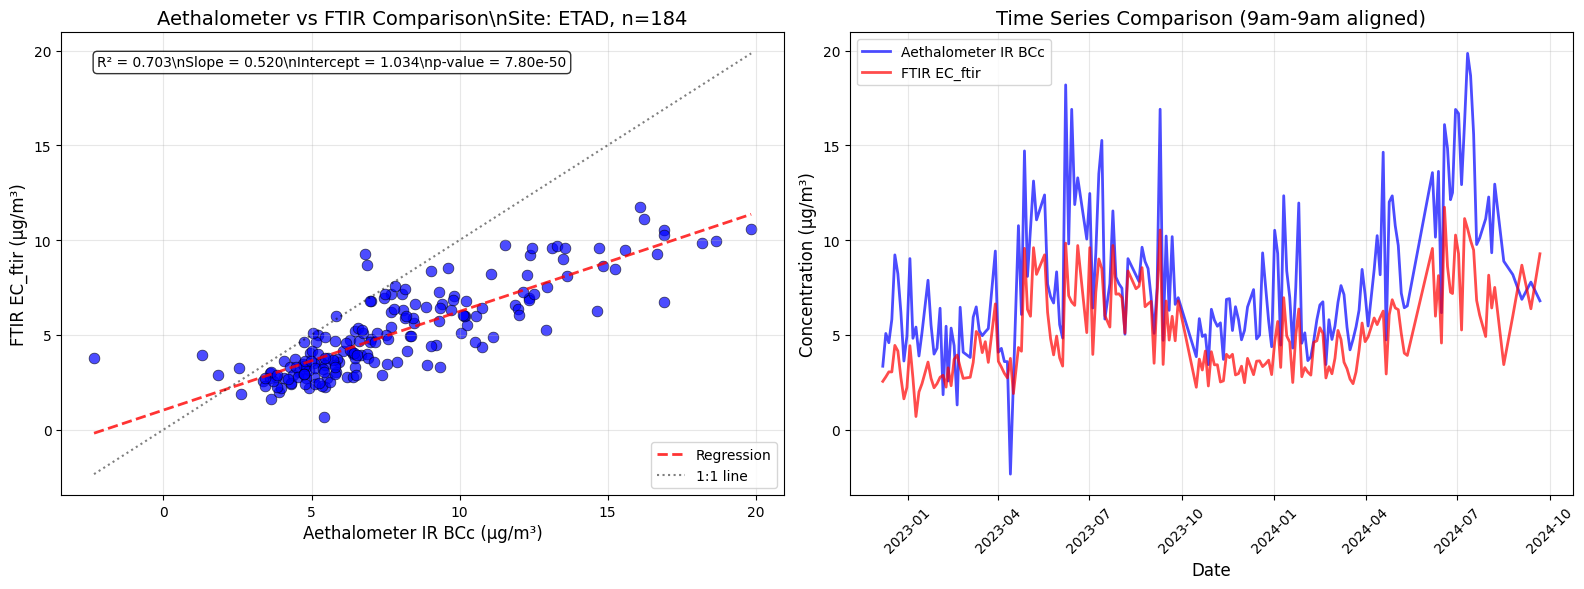


📈 Analysis Results:
  R² = 0.703
  Slope = 0.520
  Intercept = 1.034 µg/m³
  p-value = 7.80e-50
  Data points = 184

🎉 Excellent correlation! Strong agreement between methods.


In [ ]:
# %%
# Improved Analysis and plotting with explicit column selection
if 'merged_data' in locals() and len(merged_data) > 0:
    print("📊 Creating analysis plots with explicit Ethiopia correction column selection...")
    
    # Show all available columns for transparency
    print(f"\n🔍 Available columns in merged data ({merged_data.shape[1]} total):")
    all_cols = list(merged_data.columns)
    
    # Categorize columns
    ftir_cols = [col for col in all_cols if any(x in col.lower() for x in ['ec', 'oc', 'ftir'])]
    bc_original_cols = [col for col in all_cols if 'BCc' in col and 'corrected' not in col and 'manual' not in col and 'optimized' not in col]
    bc_corrected_cols = [col for col in all_cols if 'BCc' in col and 'corrected' in col]
    bc_manual_cols = [col for col in all_cols if 'BCc' in col and 'manual' in col]
    bc_optimized_cols = [col for col in all_cols if 'BCc' in col and 'optimized' in col]
    atn_cols = [col for col in all_cols if 'ATN' in col]
    
    print(f"  🧪 FTIR columns ({len(ftir_cols)}): {ftir_cols}")
    print(f"  🔧 Original BCc columns ({len(bc_original_cols)}): {bc_original_cols}")
    print(f"  ✅ Corrected BCc columns ({len(bc_corrected_cols)}): {bc_corrected_cols}")
    print(f"  📝 Manual BCc columns ({len(bc_manual_cols)}): {bc_manual_cols}")
    print(f"  🎯 Optimized BCc columns ({len(bc_optimized_cols)}): {bc_optimized_cols}")
    print(f"  📊 ATN columns ({len(atn_cols)}): {atn_cols}")
    
    # EXPLICIT COLUMN SELECTION LOGIC
    print(f"\n🎯 Explicit Column Selection Strategy:")
    
    # 1. Find FTIR EC column
    ec_col = None
    ec_candidates = ['EC_ftir', 'EC', 'Elemental Carbon']
    for candidate in ec_candidates:
        matching_cols = [col for col in ftir_cols if candidate in col]
        if matching_cols:
            ec_col = matching_cols[0]  # Take first match
            print(f"  🧪 FTIR EC column: '{ec_col}' (found via '{candidate}')")
            break
    
    if ec_col is None and ftir_cols:
        ec_col = ftir_cols[0]  # Fallback to first FTIR column
        print(f"  🧪 FTIR EC column: '{ec_col}' (fallback - first FTIR column)")
    
    # 2. Find best BC column - explicit priority order
    bc_col = None
    bc_col_type = None
    
    # Priority 1: Ethiopia-corrected columns (highest priority)
    if bc_corrected_cols:
        # Prefer IR, then Red, then others
        wavelength_priority = ['IR', 'Red', 'Blue', 'Green', 'UV']
        for wl in wavelength_priority:
            matching = [col for col in bc_corrected_cols if wl in col]
            if matching:
                bc_col = matching[0]
                bc_col_type = "Ethiopia-corrected"
                print(f"  ✅ BC column: '{bc_col}' (Ethiopia-corrected - {wl})")
                break
        
        if bc_col is None:  # Fallback to first corrected column
            bc_col = bc_corrected_cols[0]
            bc_col_type = "Ethiopia-corrected"
            print(f"  ✅ BC column: '{bc_col}' (Ethiopia-corrected - fallback)")
    
    # Priority 2: Optimized columns
    elif bc_optimized_cols:
        bc_col = bc_optimized_cols[0]
        bc_col_type = "Ethiopia-optimized"
        print(f"  🎯 BC column: '{bc_col}' (Ethiopia-optimized)")
    
    # Priority 3: Manual columns  
    elif bc_manual_cols:
        bc_col = bc_manual_cols[0]
        bc_col_type = "Ethiopia-manual"
        print(f"  📝 BC column: '{bc_col}' (Ethiopia-manual)")
    
    # Priority 4: Original BCc columns
    elif bc_original_cols:
        # Prefer IR, then Red
        for wl in ['IR', 'Red', 'Blue']:
            matching = [col for col in bc_original_cols if wl in col]
            if matching:
                bc_col = matching[0]
                bc_col_type = "Original"
                print(f"  🔧 BC column: '{bc_col}' (Original - {wl})")
                break
        
        if bc_col is None:
            bc_col = bc_original_cols[0]
            bc_col_type = "Original"
            print(f"  🔧 BC column: '{bc_col}' (Original - fallback)")
    
    print(f"\n📋 Final Selection Summary:")
    print(f"  🧪 FTIR column: {ec_col}")
    print(f"  🔧 BC column: {bc_col} ({bc_col_type})")
    
    # Verify Ethiopia corrections are being used
    if bc_col_type == "Ethiopia-corrected":
        print(f"  🎉 SUCCESS: Using Ethiopia-corrected BC data!")
    elif bc_col_type in ["Ethiopia-optimized", "Ethiopia-manual"]:
        print(f"  ✅ GOOD: Using Ethiopia-processed BC data!")
    else:
        print(f"  ⚠️  WARNING: Using original BC data - Ethiopia corrections may not be available!")
    
    # PROCEED WITH ANALYSIS if we have both columns
    if ec_col and bc_col and ec_col in merged_data.columns and bc_col in merged_data.columns:
        
        # Prepare data - remove NaN values
        print(f"\n📊 Preparing data for analysis...")
        bc_data = merged_data[bc_col].dropna()
        ec_data = merged_data[ec_col].dropna()
        
        # Get overlapping data points
        common_idx = bc_data.index.intersection(ec_data.index)
        
        print(f"  📈 BC data points: {len(bc_data)}")
        print(f"  🧪 FTIR data points: {len(ec_data)}")
        print(f"  🔗 Overlapping points: {len(common_idx)}")
        
        if len(common_idx) > 3:
            # Convert units: BC from ng/m³ to µg/m³, EC should already be in µg/m³
            x = bc_data.loc[common_idx] / 1000  # ng/m³ → µg/m³
            y = ec_data.loc[common_idx]  # Already in µg/m³
            
            print(f"  🔄 Unit conversion: BC {bc_data.loc[common_idx].median():.0f} ng/m³ → {x.median():.2f} µg/m³")
            print(f"  📏 FTIR EC range: {y.min():.2f} - {y.max():.2f} µg/m³")
            
            # Calculate regression statistics
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            
            # Create comprehensive plots
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle(f'Ethiopia Correction Analysis: {SITE_CODE}\n'
                        f'BC Column: {bc_col} ({bc_col_type})', fontsize=16, fontweight='bold')
            
            # 1. Main scatter plot with regression
            ax1 = axes[0, 0]
            scatter = ax1.scatter(x, y, alpha=0.7, color='blue', s=60, edgecolor='black', linewidth=0.5)
            
            # Regression line
            line_x = np.linspace(x.min(), x.max(), 100)
            line_y = slope * line_x + intercept
            ax1.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2, label=f'Regression (R²={r_value**2:.3f})')
            
            # 1:1 line
            max_val = max(x.max(), y.max())
            min_val = min(x.min(), y.min())
            ax1.plot([min_val, max_val], [min_val, max_val], 'k:', alpha=0.5, label='1:1 line')
            
            ax1.set_xlabel(f'Aethalometer {bc_col} (µg/m³)', fontsize=12)
            ax1.set_ylabel(f'FTIR {ec_col} (µg/m³)', fontsize=12)
            ax1.set_title(f'BC vs EC Comparison (n={len(x)})', fontsize=14)
            
            # Statistics box
            stats_text = (f'R² = {r_value**2:.3f}\n'
                         f'Slope = {slope:.3f}\n'
                         f'Intercept = {intercept:.3f}\n'
                         f'p-value = {p_value:.2e}')
            ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    verticalalignment='top', fontsize=10)
            
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # 2. Time series comparison
            ax2 = axes[0, 1]
            ax2.plot(x.index, x.values, 'b-', label=f'{bc_col_type} BC', alpha=0.8, linewidth=2)
            ax2.plot(y.index, y.values, 'r-', label=f'FTIR EC', alpha=0.8, linewidth=2)
            ax2.set_xlabel('Date', fontsize=12)
            ax2.set_ylabel('Concentration (µg/m³)', fontsize=12)
            ax2.set_title('Time Series Comparison (9am-9am aligned)', fontsize=14)
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            ax2.tick_params(axis='x', rotation=45)
            
            # 3. Residuals plot (to check correction effectiveness)
            ax3 = axes[1, 0]
            residuals = y - (slope * x + intercept)
            ax3.scatter(x, residuals, alpha=0.6, color='green', s=40)
            ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax3.set_xlabel(f'Aethalometer BC (µg/m³)', fontsize=12)
            ax3.set_ylabel('Residuals (FTIR - Predicted)', fontsize=12)
            ax3.set_title('Residuals vs BC', fontsize=14)
            ax3.grid(True, alpha=0.3)
            
            # Add residual statistics
            residual_std = residuals.std()
            ax3.text(0.05, 0.95, f'Residual σ = {residual_std:.3f}', 
                    transform=ax3.transAxes, fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # 4. Data quality assessment
            ax4 = axes[1, 1]
            
            # Show correlation with ATN1 if available (to verify Ethiopia fix effectiveness)
            atn_col = None
            for col in atn_cols:
                if any(wl in col for wl in ['IR', 'Red']) and 'ATN1' in col:
                    atn_col = col
                    break
            
            if atn_col and atn_col in merged_data.columns:
                atn_data = merged_data.loc[common_idx, atn_col]
                bc_atn_corr = x.corr(atn_data)
                
                ax4.scatter(atn_data, x, alpha=0.6, s=40, color='orange')
                ax4.set_xlabel(f'{atn_col}', fontsize=12)
                ax4.set_ylabel(f'BC (µg/m³)', fontsize=12)
                ax4.set_title(f'BC vs ATN1 (r={bc_atn_corr:.3f})', fontsize=14)
                ax4.grid(True, alpha=0.3)
                
                # Assess Ethiopia fix effectiveness
                if abs(bc_atn_corr) < 0.1:
                    effectiveness = "Excellent"
                    color = "green"
                elif abs(bc_atn_corr) < 0.2:
                    effectiveness = "Good"
                    color = "orange"
                else:
                    effectiveness = "Needs improvement"
                    color = "red"
                    
                ax4.text(0.05, 0.95, f'Ethiopia fix: {effectiveness}', 
                        transform=ax4.transAxes, fontsize=10, color=color, weight='bold',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            else:
                # Show BC distribution instead
                ax4.hist(x, bins=30, alpha=0.7, color='blue', edgecolor='black')
                ax4.set_xlabel(f'BC Concentration (µg/m³)', fontsize=12)
                ax4.set_ylabel('Frequency', fontsize=12)
                ax4.set_title('BC Distribution', fontsize=14)
                ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # COMPREHENSIVE RESULTS SUMMARY
            print(f"\n📈 COMPREHENSIVE ANALYSIS RESULTS:")
            print(f"=" * 50)
            print(f"🏢 Site: {SITE_CODE}")
            print(f"🔧 BC Method: {bc_col_type}")
            print(f"📊 Data Points: {len(x)}")
            print(f"📅 Date Range: {x.index.min().date()} to {x.index.max().date()}")
            print(f"")
            print(f"📊 CORRELATION ANALYSIS:")
            print(f"  R² = {r_value**2:.3f}")
            print(f"  Correlation (r) = {r_value:.3f}")
            print(f"  Slope = {slope:.3f}")
            print(f"  Intercept = {intercept:.3f} µg/m³")
            print(f"  p-value = {p_value:.2e}")
            print(f"  Standard Error = {std_err:.3f}")
            
            print(f"\n🎯 ETHIOPIA FIX ASSESSMENT:")
            if bc_col_type == "Ethiopia-corrected":
                print(f"  ✅ Using optimal Ethiopia corrections")
                if atn_col:
                    print(f"  📊 BC-ATN1 correlation: {bc_atn_corr:.3f}")
                    if abs(bc_atn_corr) < 0.1:
                        print(f"  🎉 Excellent fix effectiveness (low BC-ATN1 correlation)")
                    elif abs(bc_atn_corr) < 0.2:
                        print(f"  👍 Good fix effectiveness")
                    else:
                        print(f"  ⚠️ Fix may need refinement")
            elif bc_col_type in ["Ethiopia-optimized", "Ethiopia-manual"]:
                print(f"  ✅ Using Ethiopia-processed data")
            else:
                print(f"  ⚠️ Using original data - no Ethiopia corrections applied")
            
            print(f"\n🔬 INTERPRETATION:")
            if r_value**2 > 0.8:
                print(f"  🎉 Excellent agreement between aethalometer and FTIR!")
                print(f"  📏 Methods are highly consistent")
            elif r_value**2 > 0.6:
                print(f"  👍 Good agreement between methods")
                print(f"  📊 Strong linear relationship")
            elif r_value**2 > 0.4:
                print(f"  📊 Moderate agreement - acceptable for research")
                print(f"  🔍 Consider data quality or methodological differences")
            elif r_value**2 > 0.2:
                print(f"  ⚠️ Weak agreement - investigate data quality")
                print(f"  🔧 May need additional corrections or filtering")
            else:
                print(f"  ❌ Poor agreement - significant issues present")
                print(f"  🚨 Requires thorough investigation")
                
        else:
            print(f"⚠️ Insufficient overlapping data points ({len(common_idx)}) for analysis")
            print(f"  📊 BC data points: {len(bc_data)}")
            print(f"  🧪 FTIR data points: {len(ec_data)}")
            print(f"  📅 Date range overlap issue - check temporal alignment")
            
    else:
        print(f"❌ Cannot proceed with analysis:")
        if not ec_col:
            print(f"  🧪 No FTIR EC column found")
        elif ec_col not in merged_data.columns:
            print(f"  🧪 FTIR column '{ec_col}' not in merged data")
        if not bc_col:
            print(f"  🔧 No BC column found")
        elif bc_col not in merged_data.columns:
            print(f"  🔧 BC column '{bc_col}' not in merged data")
            
        print(f"\n🔍 Available columns for debugging:")
        for i, col in enumerate(merged_data.columns):
            print(f"    {i:2d}. {col}")

else:
    print("❌ No merged data available for analysis - check previous steps")

In [8]:
# Save results and summary
if 'merged_data' in locals() and len(merged_data) > 0:
    print("💾 Saving results...")
    
    # Save merged data
    output_file = f"aethalometer_ftir_merged_{SITE_CODE.lower()}_9am.pkl"
    merged_data.to_pickle(output_file)
    print(f"✅ Saved merged data to: {output_file}")
    
    # Save as CSV for easy viewing
    csv_file = f"aethalometer_ftir_merged_{SITE_CODE.lower()}_9am.csv"
    merged_data.to_csv(csv_file)
    print(f"✅ Saved CSV version to: {csv_file}")
    
    print(f"\n📋 Final Summary:")
    print(f"  🏢 Site: {SITE_CODE}")
    print(f"  📊 Total merged data points: {len(merged_data)}")
    print(f"  📅 Date range: {merged_data.index.min()} to {merged_data.index.max()}")
    print(f"  🔧 Aethalometer columns: {len([c for c in merged_data.columns if any(x in c for x in ['BCc', 'BC1', 'ATN'])])}")
    print(f"  🧪 FTIR columns: {len([c for c in merged_data.columns if any(x in c.lower() for x in ['ec', 'oc'])])}")
    
else:
    print("⚠️ No data to save")

print(f"\n🎯 Pipeline Complete!")
print(f"✅ FTIR data loaded from CSV")
print(f"✅ 9am-to-9am alignment applied")
print(f"✅ Data merged and analyzed")
print(f"✅ Results saved")

💾 Saving results...
✅ Saved merged data to: aethalometer_ftir_merged_etad_9am.pkl
✅ Saved CSV version to: aethalometer_ftir_merged_etad_9am.csv

📋 Final Summary:
  🏢 Site: ETAD
  📊 Total merged data points: 189
  📅 Date range: 2022-12-07 09:00:00+03:00 to 2024-09-21 09:00:00+03:00
  🔧 Aethalometer columns: 76
  🧪 FTIR columns: 8

🎯 Pipeline Complete!
✅ FTIR data loaded from CSV
✅ 9am-to-9am alignment applied
✅ Data merged and analyzed
✅ Results saved
